# Projektna naloga pri Uvodu v programiranje
## Pridobivanje podatkov

Za dostop do informacij o točkah ELO (ter tudi nekaterih drugih podatkih) najboljših 100 šahistov med leti 2000 ter 2024, bomo uporabljali spletišče Mednarodne šahovske federacije (FIDE): https://ratings.fide.com/. O spletišču pa najprej omenim naslednje zanimivosti:

Tipična URL povezava do tabele o najboljših šahistih neke kategorije za dani mesec je oblike: https://ratings.fide.com/toparc.phtml?cod=1 ; kjer končnica cod parametrizira zaporedni vnos podatkov. Opaziomo, da v odvisnosti od num modulo 4 dobimo sledeče kategorije šahistov:

|   cod    |  mod 4  |
| -------- | ------- |
|    1     | odprta kategorija   |
|    2     | ženska kategorija     |
|    3     | kategorija juniorjev   |
|    4     | kategorija juniork |

Za vrednost cod=1 pa dobimo tabelo s podatki o najboljših 100 šahistih v odprti sekciji za mesec julij leta 2000, za vrednost cod=5 dobimo tabelo s podatki o najboljših šahistih v odpri sekciji za mesec oktober leta 2000 ipd.

Z nekaj ročne analize (ter z pomočjo bisekcije) ugotovimo, da so med julijem leta 2000 (cod=1) in julijem leta 2009 (cod=145) tabelo objavljali vsake tri mesece (januar, april, julij ter oktober); nakar je prišlo do spremembe. Od septembra 2009 (cod=149) do maja 2012 (cod=213) pa so tabelo objavljali vsak drugi mesec (januar, marec, maj, julij, september, november), nato pa so prešli na trenutni sistem mesečnih objav tabel, ki velja od julija 2012 (cod=217).

|   Pogostost    |  Trajanje  | cod |
| -------- | ------- | --------- |
|    3x letno     |  julij 2000 - julij 2009  | 1 - 145 |
|    6x letno     | september 2009 - maj 2012 | 145 - 217|
|    12x letno    | julij 2012 - | 217  - |

To sicer ni preveč relevantno za pridobivanje podatkov, saj informacijo o datumu pridobimo tako, da preberemo HTML, je pa relevantno za analizo podatkov. Ker se količina informacij, ki jih imamo za npr. leto 2000 (le dve tabeli) občutno razlikuje od količine informacij, ki jih imamo za leto 2023 (12 tabel) in ker pri računanju povprečja uporabimo preprosto aritmetično sredino je pričakovano, da bodo povprečja bolj reprezentativna kasnejših podatkov.

Za uspešno pridobivanje podatkov sledite navodilom v datoteki ```README.md```

In [1]:
import pandas as pd
import os
from statistics import mean
import matplotlib.pyplot as plt
import funkcije
import analiza_funkcije as af

pot_plitka = os.getcwd()
pot_globoka =  os.path.join(pot_plitka, 'podatkovna_baza')
pot_sahisti = os.path.join(pot_plitka, 'sahisti')

Preden začnemo z analizo podatkov opazimo, da so nekatera imena v podatkovni bazi podvojena; primer je Garry Kasparov ter Gary Kasparov. Do tega pride, ker so občasno imena v FIDE podatkovni bazi zapisana z kakšno črko razlike ali pa z dodatnim/odvečnim drugim imenom.

Ker pa si želimo, da podatke, ki očitno pripadajo istemu šahistu analiziramo kot take, bomo vse .csv datoteke, za katere menimo, da predstavljajo istega šahista, združili. Najprej zberemo imena, za katera mislimo, da pripadajo isti osebi v seznam seznamov imen.

In [2]:
ekvivalence = [['Sadler, Matthew', 'Sadler, Matthew D'],['Dominguez Perez, Lenier', 'Dominguez Perez, Leinier'],['Kasparov, Gary', 'Kasparov, Garry'], ['Bologan, Victor', 'Bologan, Viktor'], ['Bruzon, Lazaro', 'Bruzon Batista, Lazaro'], ['Dreev, Alexey', 'Dreev, Aleksey'], ['Harikrishna, Pentala', 'Harikrishna, P'], ['Iturrizaga, Eduardo', 'Iturrizaga Bonelli, Eduardo'], ['Ivanchuk, Vassily', 'Ivanchuk, Vasyl'], ['Kobalia, Mikhail', 'Kobalija, Mihail'], ['Mamedyarov, Shakhriyar', 'Mamedyarov, Shakhriyaz'], ['Narayanan S L', 'NarayananSL'], ['Polgar, Judit (GM)', 'Polgar, Judit'], ['Shankland, Sam', 'Shankland, Samuel', 'Shankland, Samuel L']]
nova_imena = [ime[0] for ime in ekvivalence]

af.popravljalnik(ekvivalence, nova_imena)

Odlično, sedaj smo opravili z podvojenimi (ter v enem primeru potrojenimi) podatki.

## Analiza podatkov
Sedaj si poglejmo nekaj zbranih podatkov.

In [3]:
sahisti_prikaz_df = pd.DataFrame(af.pridobi_splosne_informacje(), columns=['Ime', 'Leto rojstva', 'Drzava', 'Najvišji rating'])

sahisti_prikaz_df.head(15)

,Ime,Leto rojstva,Drzava,Najvišji rating
0,"Kramnik, Vladimir",1975,RUS,2817
1,"Anand, Viswanathan",1969,IND,2817
2,"Morozevich, Alexander",1977,RUS,2788
3,"Adams, Michael",1971,ENG,2761
4,"Shirov, Alexei",1972,ESP,2755
5,"Leko, Peter",1979,HUN,2763
6,"Ivanchuk, Vassily",1969,UKR,2787
7,"Topalov, Veselin",1975,BUL,2816
8,"Krasenkow, Michal",1963,POL,2702
9,"Bareev, Evgeny",1966,RUS,2739


Prva stvar ki nas zanima je pri kateri starosti šahisti dosežejo svoj vrhunec. Postopek, da pridobimo to informacijo bo naslednji:
1. Ustvarili bomo kopijo seznama sahisti ter v to kopijo shranili podatke o tem pri kateri starosti šahist doseže svoj največji ELO rating; podobno bomo naredili tudi z podatkom pri kateri starosti šahist doseže svoj največji indeks na lestvici najboljših 100 šahistov. Ta podatka nista nujno enakovredna, zaradi rating inflationa ([relevanten wikipedia snippet](https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details)).
2. Statistično analizirali zbrano.
3. Zbrane podatke grafično prikazali.

Naš prvi korak bo, da analiziramo ELO šahista v odvisnosti od starosti šahista. To bomo storili tako, da za vsakega šahista, o katerim imamo informacije, izračunamo rating pri določeni starosti ter te podatke predstavimo z diagramom.

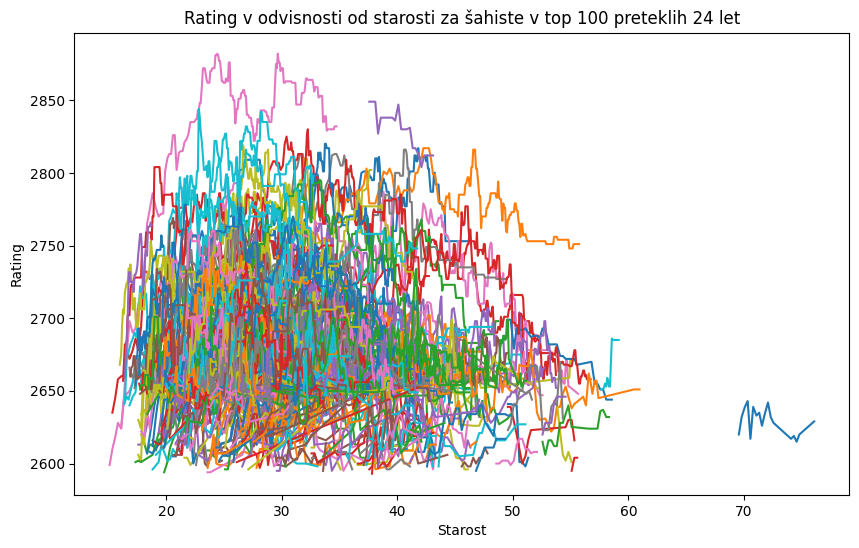

In [4]:
plt.figure(figsize=(10,6))
for kljucni_nabor, podatki in af.podatki_top_nekaj(100).items():
    #Seznam podatkov o datumih nadomestimo z seznamom podatkov starosti posameznega šahista
    podatki_starost = [round(funkcije.datum_v_float(datum) - kljucni_nabor[1],2) for datum in podatki['datum']]
    plt.plot(podatki_starost, podatki['rating'], label = kljucni_nabor[0])
plt.title('Rating v odvisnosti od starosti za šahiste v top 100 preteklih 24 let')
plt.xlabel('Starost')
plt.ylabel('Rating')
plt.show()

Opazimo izjemo v mordi črti, ki se giblje okoli 73 leta ter ratinga 2625. Le kdo bi to lahko bil?

In [5]:
for kljucni_nabor, podatki in af.podatki_top_nekaj(100).items():
    for datum in podatki['datum']:
        if int(funkcije.datum_v_float(datum) - kljucni_nabor[1]) > 70:
            print(kljucni_nabor[0])
            break

Korchnoi, Viktor


Ugotovili smo, da je to Viktor Korchnoi; dvakratni izzivalec svetovnega prvaka v šahu Anatolyja Krapova. Korchnoi je znan po svoji šahovski aktivnosti v poznejših letih, kot vidimo je bil med najboljšimi 100 šahisti na svetu celo v svojih 70ih. Šahisti se praviloma upokojijo iz profesionalnega šaha dosti prej, svetovni prvak Garry Kasparov se je na primer upokojil pri 42 letih.

Diagram žal ni najbolj berljiv. S tem se spopademo na sledeči način:

V zgornji celici smo izluščili informacije o ELO ratingov šahistov ob starostih, za celotno populacijo šahistov. Morda pa bi dobili bolj berljive informacije, če bi enako naredili za celotno populacijo šahistov, za katere imamo informacije, ter nato te podatke povprečili.

Pri tej starosti povprečni šahist v naši populaciji doseže svoj najvišji rating: 31. 
Ta rating je 2703.


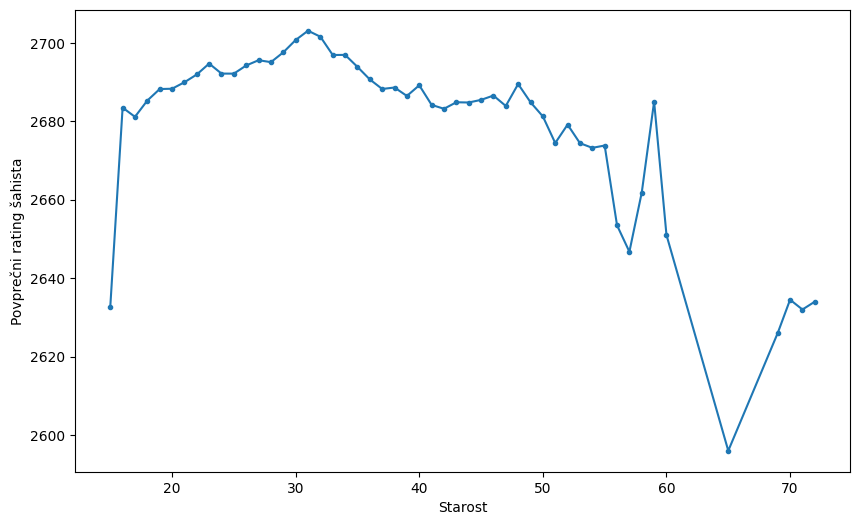

In [6]:
povprecje_v_populaciji_100 = af.povprecje_v_populaciji(100)
maksimum_v_populaciji_100 = af.maksimum_v_povprecju_populacije(povprecje_v_populaciji_100, 100)[0]
najvisji_rating_v_populaciji_100 = af.maksimum_v_povprecju_populacije(povprecje_v_populaciji_100, 100)[1]

formatirani_ekstrem_100 = ' ,'.join(f'{stevilo}' for stevilo in maksimum_v_populaciji_100)
print(f'Pri tej starosti povprečni šahist v naši populaciji doseže svoj najvišji rating: {formatirani_ekstrem_100}. \nTa rating je {najvisji_rating_v_populaciji_100}.')


pandas_prikaz_top_100 = pd.Series(povprecje_v_populaciji_100)

plt.figure(figsize=(10,6))

pandas_prikaz_top_100.plot(kind = 'line', marker = '.')
plt.xlabel('Starost')
plt.ylabel('Povprečni rating šahista')
plt.show()

Dobili smo trend, ki bi ga verjetno lahko predvideli. Šahist v povpreču svoj elo viša v svojih 20ih letih, doseže maksimum pri 31 letih (v povprečju je to 2703), nato pa mu rating počasi začne padati.

Špico pri 60ih letih ter preobrat pri 65 letih lahko predpišemo dejstvu, da o tej demografiki nimamo veliko podatkov, saj se večina šahistov pred to starostjo bodisi upokoji, bodisi izpade iz top 100. Posledično so iregularnosti, ki jih vidimo, pričakovane.

Morda pa nas želja po bolj regularnih diagramih ter naše elitistične težnje vodijo do tega, da bi si radi ogledali še podatke le o najboljših izmed najboljših. Poglejmo si iste informacije o populaciji šahistov, ki so v svoji karieri dosegli mesto med najboljšimi 5 šahisti na FIDE lestvici.

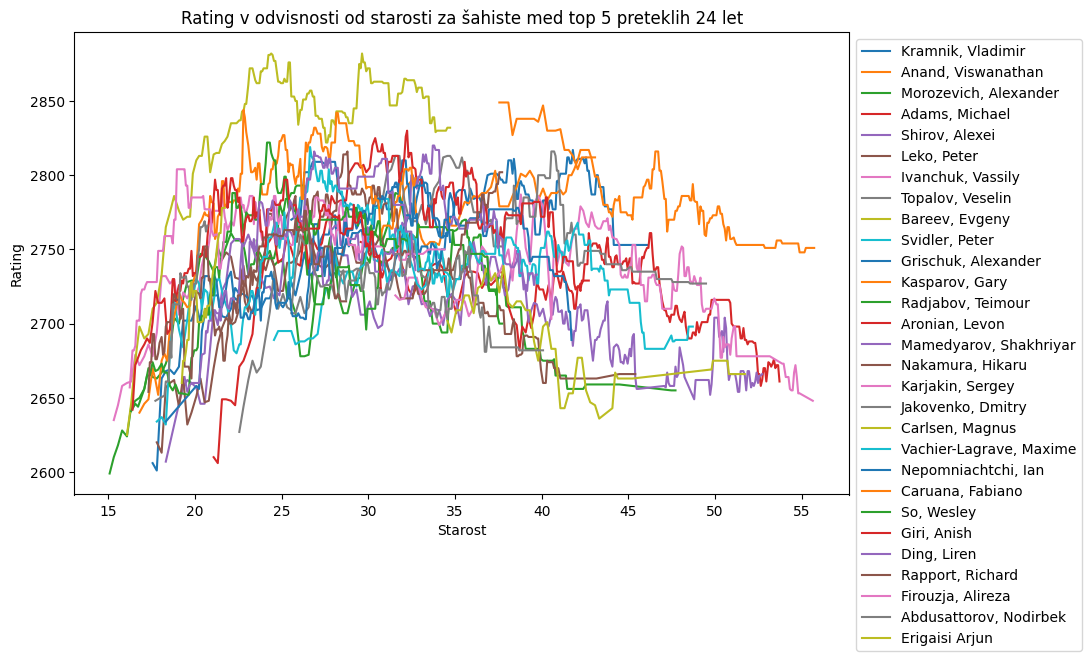

In [7]:
plt.figure(figsize=(10,6))
for kljucni_nabor, podatki in af.podatki_top_nekaj(5).items():
    #Seznam podatkov o datumih nadomestimo z seznamom podatkov starosti posameznega šahista
    podatki_starost = [round(funkcije.datum_v_float(datum) - kljucni_nabor[1],2) for datum in podatki['datum']]
    plt.plot(podatki_starost, podatki['rating'], label = kljucni_nabor[0])
plt.title('Rating v odvisnosti od starosti za šahiste med top 5 preteklih 24 let')
plt.legend(bbox_to_anchor = (1,1))
plt.xlabel('Starost')
plt.ylabel('Rating')
plt.show()

Kot poprej poglejmo še povprečje te demografike.

Pri tej starosti povprečni šahist, ki je dosegel mesto med najboljšimi petimi šahisti na svetu, doseže svoj najvišji rating: 28. 
Ta rating je 2772.


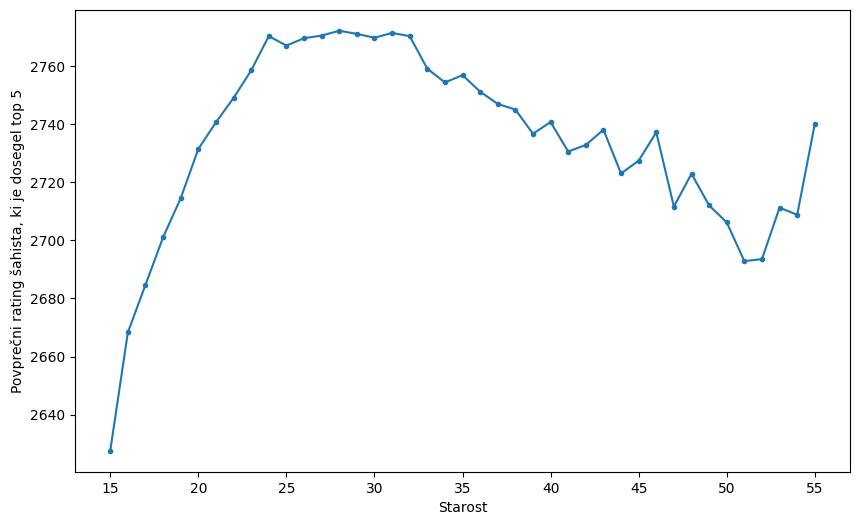

In [8]:
povprecje_v_populaciji_5 = af.povprecje_v_populaciji(5)
maksimum_v_populaciji_5 = af.maksimum_v_povprecju_populacije(povprecje_v_populaciji_5, 5)[0]
najvisji_rating_v_populaciji_5 = af.maksimum_v_povprecju_populacije(povprecje_v_populaciji_5, 5)[1]

formatirani_ekstrem_5 = ' ,'.join(f'{stevilo}' for stevilo in maksimum_v_populaciji_5)
print(f'Pri tej starosti povprečni šahist, ki je dosegel mesto med najboljšimi petimi šahisti na svetu, doseže svoj najvišji rating: {formatirani_ekstrem_5}. \nTa rating je {najvisji_rating_v_populaciji_5}.')

pandas_prikaz_top_5 = pd.Series(povprecje_v_populaciji_5)

plt.figure(figsize=(10,6))

pandas_prikaz_top_5.plot(kind = 'line', marker = '.')

plt.xlabel('Starost')
plt.ylabel('Povprečni rating šahista, ki je dosegel top 5')
plt.show()

Opazimo podoben trend, ki predvidi oster vzpon do približno 24 leta, ter nato relativno nespreminjujoč rating vse do približno 34 leta, čemur sledi počasno nižanje ELO ratinga.

Povprečni šahist, ki je v življenju dosegel mesto med top 5 na FIDE lestvici, svoj najvišji rating (v povprečju 2772) doseže pri 28 letu.

Kaj pa le tisti, ki imajo v neki točki v času najvišji ELO na svetu?

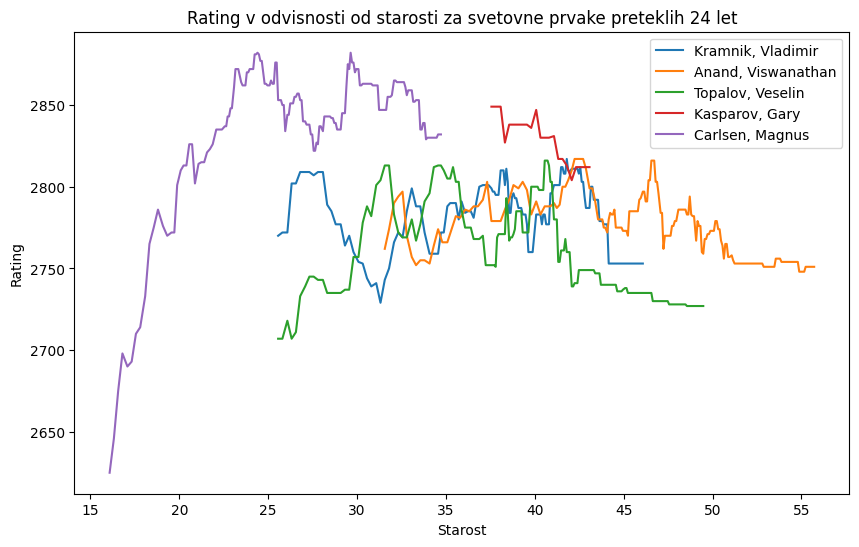

In [9]:
plt.figure(figsize=(10,6))
for kljucni_nabor, podatki in af.podatki_top_nekaj(1).items():
    #Seznam podatkov o datumih nadomestimo z seznamom podatkov starosti posameznega šahista
    podatki_starost = [round(funkcije.datum_v_float(datum) - kljucni_nabor[1],2) for datum in podatki['datum']]
    plt.plot(podatki_starost, podatki['rating'], label = kljucni_nabor[0])
plt.title('Rating v odvisnosti od starosti za svetovne prvake preteklih 24 let')
plt.legend(bbox_to_anchor = (1,1))
plt.xlabel('Starost')
plt.ylabel('Rating')
plt.show()

In ponovno v povprečju.

Pri tej starosti povprečni šahist, ki je dosegel prvo mesto na svetu, doseže svoj najvišji rating: 24. 
Ta rating je 2873.


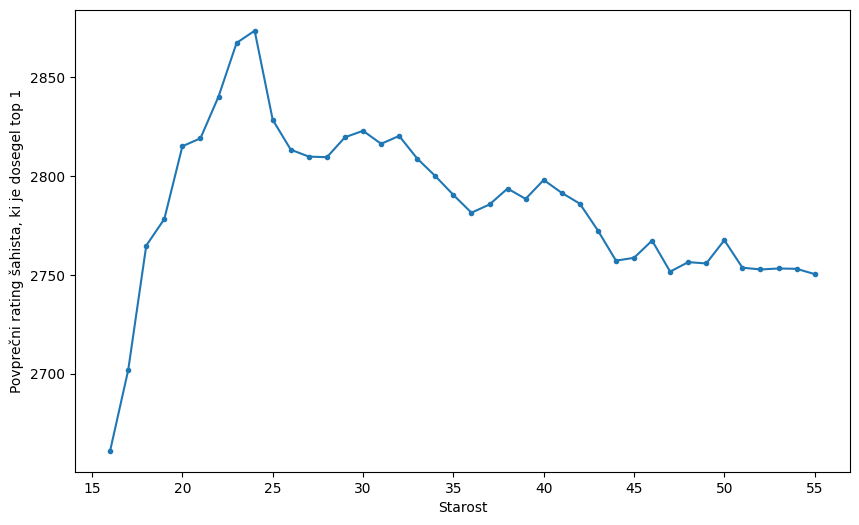

In [10]:
povprecje_v_populaciji_1 = af.povprecje_v_populaciji(1)
maksimum_v_populaciji_1 = af.maksimum_v_povprecju_populacije(povprecje_v_populaciji_1, 1)[0]
najvisji_rating_v_populaciji_1 = af.maksimum_v_povprecju_populacije(povprecje_v_populaciji_1, 1)[1]

formatirani_ekstrem_1 = ' ,'.join(f'{stevilo}' for stevilo in maksimum_v_populaciji_1)
print(f'Pri tej starosti povprečni šahist, ki je dosegel prvo mesto na svetu, doseže svoj najvišji rating: {formatirani_ekstrem_1}. \nTa rating je {najvisji_rating_v_populaciji_1}.')

pandas_prikaz_top_1 = pd.Series(povprecje_v_populaciji_1)

plt.figure(figsize=(10,6))

pandas_prikaz_top_1.plot(kind = 'line', marker = '.')

plt.xlabel('Starost')
plt.ylabel('Povprečni rating šahista, ki je dosegel top 1')
plt.show()

Prvouvrščeni na FIDE lestvici svoj najvišji rating (v povprečju 2873) dosežejo pri 24 letu. Njihov rating sledi podobnim trendom kot pri že analiziranih demografikah.

Iz čiste radovednosti narišimo grafe povprečnega šahista v naši podatkovni bazi, povprečnega šahista, ki je dosegel rating med top 5, ter šahista, ki je dosegel rang 1, na isti diagram.

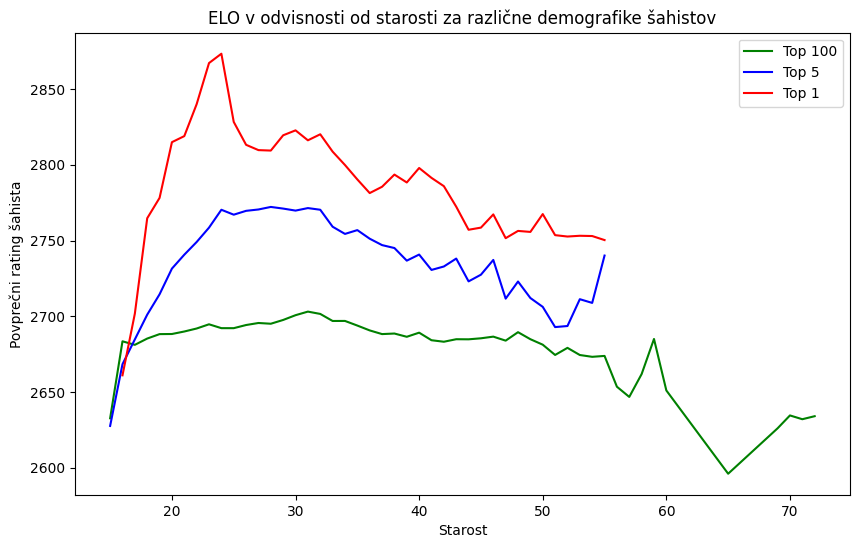

In [11]:
plt.figure(figsize=(10,6))

pandas_prikaz_top_100.plot(label='Top 100', color='green')
pandas_prikaz_top_5.plot(label='Top 5', color='blue')
pandas_prikaz_top_1.plot(label='Top 1', color='red')

plt.xlabel('Starost')
plt.ylabel('Povprečni rating šahista')
plt.title('ELO v odvisnosti od starosti za različne demografike šahistov')

plt.legend()
plt.show()

|Demografika| Najvišji rating | Starost pri najvišjem ratingu|
|-----------|-----------------|------------------------------|
|Povprečje populacije top 100 šahistov| 2703 | 31 |
|Povprečje populacije top 5 šahistov| 2772 | 28 |
|Povprečje populacije top 1 šahistov| 2873 | 24 |

Vidimo, da se razvoj šahistovega ELO ratinga skozi njegovo življenje zelo razlikuje, če vemo, da dotični šahist doseže mesto med najboljšimi 100 (zelena črta), najboljšimi 5 (morda črta), ter najboljši med vsemi (rdeča črta). Ne samo da 'boljši' šahisti dosegajo svoj maksimum pri višjih ratingih, kar je samoumevno, tudi dosegajo ga kot mlajši, in to ne za zanemarljivo količino.

Preden nadaljujemo pa je treba dodati, da naša statistična analiza ni brez svojih primanjkljajev. Ker so nam na voljo le podatki o šahistih med letom 2000 in letom 2024, so zbrani podatki o šahistih, ki so bili na lestvici tudi pred letom 2000, nereprezentativni. Seveda, mar res pričakujemo, da se je (kot lahko vidimo na grafu 'Rating v odvisnosti od starosti za svetovne prvake preteklih 24 let') Gary Kasparov kar pojavil z ELO ratingom čez 2800?

Do sedaj pa se še nismo poslužili enega izmed podatkov, ki smo jih zbrali. To je namreč država, pod zastavo katere igra posamezni šahist.
Pojavljajo se nam naslednja vprašanja:
* Kakšen delež šahistov predstavljajo posamezne države?
* Ali obstaja povezava med šahistovo državo ter njegovim raingom?

Lotimo se najprej prve točke.

{'RUS': 4254, 'IND': 986, 'ENG': 810, 'ESP': 432, 'LAT': 111, 'HUN': 783, 'UKR': 1552, 'BUL': 400, 'FID': 255, 'POL': 434, 'CAN': 34, 'UZB': 286, 'ISR': 579, 'GEO': 195, 'CHN': 1478, 'BEL': 29, 'TUR': 41, 'ARM': 774, 'SVK': 45, 'CZE': 339, 'MKD': 15, 'GER': 478, 'BIH': 55, 'FRA': 812, 'SLO': 80, 'NED': 509, 'USA': 1407, 'BLR': 133, 'SWE': 89, 'SIN': 4, 'SGP': 1, 'BRA': 31, 'EST': 13, 'SUI': 68, 'DEN': 112, 'CRO': 110, 'PER': 125, 'KAZ': 59, 'MDA': 93, 'LTU': 10, 'ROM': 44, 'IRL': 1, 'ROU': 149, 'INA': 1, 'CUB': 208, 'ISL': 18, 'GRE': 10, 'AZE': 772, 'MAR': 2, 'CYP': 2, 'IRI': 112, 'ARG': 19, 'NOR': 226, 'PHI': 46, 'SCG': 1, 'TJK': 8, 'SRB': 69, 'FIN': 8, 'ITA': 57, 'VIE': 177, 'AUT': 126, 'VEN': 24, 'EGY': 109, 'PAR': 2, 'UAE': 64}


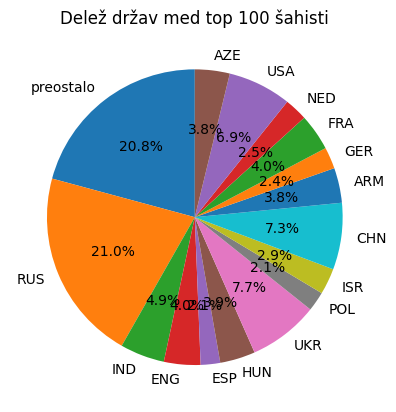

In [23]:
pogostost_drzav, prazne_drzave, stevilo_podatkov, meja, najproduktivnejsa_drzava  = af.drzave_splosne_informacije()

pogostost_drzav_nad_mejo, drzave_nad_mejo = af.pogostost_drzav_nad_mejo(pogostost_drzav, meja)

pogostost_drzav_nad_mejo_pandas = pd.Series(pogostost_drzav_nad_mejo)

pogostost_drzav_nad_mejo_pandas.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Delež držav med top 100 šahisti')
plt.ylabel('')
plt.show()

Naredimo še bolj berljiv tortni diagram, ki ne vsebuje procentov.

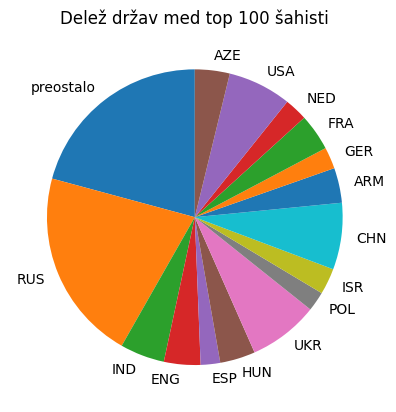

{'ESP', 'HUN', 'GER', 'USA', 'IND', 'ARM', 'ENG', 'ISR', 'AZE', 'CHN', 'FRA', 'NED', 'UKR', 'RUS', 'POL'}
Država, ki prispeva največ podatkov k naši analizi je RUS, ki prispeva 21.0% podatkov


In [37]:
pogostost_drzav_nad_mejo_pandas.plot.pie(startangle=90)
plt.title('Delež držav med top 100 šahisti')
plt.ylabel('')
plt.show()

print(drzave_nad_mejo)
print(f'Država, ki prispeva največ podatkov k naši analizi je {najproduktivnejsa_drzava[0]}, ki prispeva {najproduktivnejsa_drzava[1] / stevilo_podatkov * 100:.1f}% podatkov')

Zaradi berljivosti se je avtor odločil prikazati le države, katerih igralci prispevajo vsaj 2% informacji, ki smo jih zbrali. Te države so naštete pod diagramom zgoraj.

Daleč največji delež, več kot petino, podatkov prispeva Rusija, kar je pričakovano glede na dolgo šahovsko tradicijo te države.

Lotimo se še druge točke: kakšna je povezava med šahistovo državo ter njegovim ratingom?

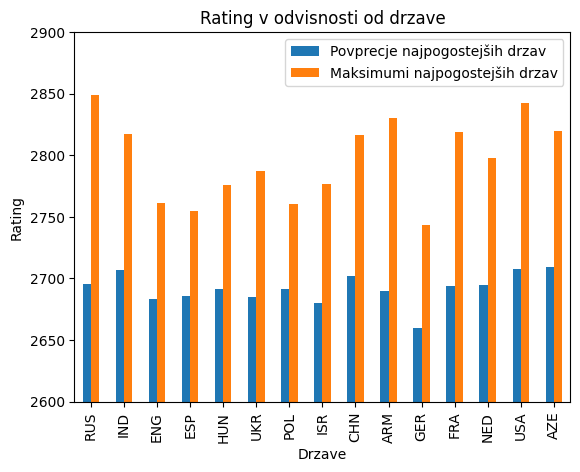

In [38]:
drzave = af.ustvarjalec_drzav(prazne_drzave)
drzave_nad_mejo_info = af.informacije_o_mnozici_drzav(drzave_nad_mejo, drzave)
drzave_nad_mejo_v_povprecju = af.kalkulator_povprecja(drzave_nad_mejo_info)
drzave_nad_mejo_maksimumi = af.ustvarjalec_maksimumom_drzav(drzave_nad_mejo_info)

drzave_nad_mejo_v_povprecju_df = pd.DataFrame({'Povprecje najpogostejših drzav': drzave_nad_mejo_v_povprecju, 'Maksimumi najpogostejših drzav' : drzave_nad_mejo_maksimumi})

drzave_nad_mejo_v_povprecju_df.plot(kind = 'bar')
plt.ylim(2600, 2900)
plt.title('Rating v odvisnosti od drzave')
plt.xlabel('Drzave')
plt.ylabel('Rating')
plt.legend()
plt.show()

Nazoren diagram, a žal ne prepoznamo katere izmed držav so najboljše v posamezni metriki. 
ZDA, Azerbajdžan, Kitajska ter Indija so navidezno izenačeni pri modrih stolpcih, Rusija, ZDA ter Armenija pa pri oranžnih stolpcih.
Napišimo nekaj vrstic kode, ki razjasni situacijo.

In [39]:
povprecje_drzave_v_tekmovanju = {i : drzave_nad_mejo_v_povprecju[i] for i in {'IND', 'CHN', 'USA', 'AZE'}}
print(f'Naslednje so točne informacije o povprečnem ratingu igralcev nekaterih držav: {povprecje_drzave_v_tekmovanju}')

maksimumi_drzave_v_tekomvanju = {i : drzave_nad_mejo_maksimumi[i] for i in {'RUS', 'USA', 'ARM'}}
print(f'Naslednje so točne informacije o najvišjem ratingu igralcev nekaterih držav: {maksimumi_drzave_v_tekomvanju}')

Naslednje so točne informacije o povprečnem ratingu igralcev nekaterih držav: {'CHN': 2701.63, 'USA': 2707.66, 'AZE': 2709.18, 'IND': 2706.65}
Naslednje so točne informacije o najvišjem ratingu igralcev nekaterih držav: {'USA': 2842, 'RUS': 2849, 'ARM': 2830}


Zaključki so jasni, povprečni šahist, ki igra za ZDA ter Indijo ima rating približno 2708, povprečni Azerbajdžanski šahist pa približno 2709.

Glede najvišjih ratingov preko celotne kariere šahistov, izstopajo ZDA, Rusija ter Armenija; zmagovalec v tej kategoriji pa so ZDA, saj imajo nek njihov šahist na FIDE lestvici najvišji rating 2842.

Seveda tudi ta del analize ni brez napak ter netočnosti; pri analizi povprečnega ter najvišjega ratinga držav se na primer ni pojavila Norveška, katere prvak Magnus Carlsen ima trenutno rating 2832. Temu je tako, ker Norveška ne prispeva zadostnega deleža podatkov, kar pomeni, da so igralci te države vključeni v skupino 'preostalo', ki je nisem upošteval pri analizi ratinga v odvisnosti od države.

Tako sem se odločil, saj sem želel z to analizo prikazati katere države imajo močne šahovske tradicije, kar odraža prisotnost šahistov iz te države na FIDE top 100 lestvici. Potencial in možnost za uspehe posameznika je namreč prisoten povsod.

## Zaključek

Pri analizi ratinga v odvisnosti od starosti smo prišli do treh jasnih zaključkov:
* Graf ratinga v odvinosti od starosti ima predvidljivo strukturo - hitro naraščanje do maksimuma, ki mu sledi počasen zaton.
* Šahisti z večjim rangom imajo v povprečju večji rating.
* 'Boljši' šahisti dosežejo vrhunec svojega ratinga prej v življenju.

Pri analizi ratinga v odvinosti od države izvora smo prišli do treh zaključkov:
* Rusija, država z močno šahovsko tradicijo, oz. njeni šahisti predstavljajo petino vseh zbranih podatkov. Azerbajdžan ter Armenija, ki sta relativno majhni državi, z močno šahovsko tradicijo, tudi prispevata nekarakteristično visoko količino podatkov.
* Izmed 'večjih' šahovskih držav ima povprečen Azerbaijdžanec najvišji rating izmed vseh držav.
* Izmed 'večjih' šahovskih držav ima najvišji rating posameznika Rusija.

Že tekom analize podatkov sem izpostavil nekatere napake, netočnosti ter predpostavke smo zagrešili, posledično je ponavljanje slednjih v tem poglavju odveč.

Zbranih podatkov gotovo nismo analizirali izčrpno, morebitnih povezav ter trendov v podatkovnih kategorijah, ki jih sploh nismo uporabili (rang ter število odigranih iger), je mnogo. Prav tako je bila izbira, da obravnavamo le odprto kategorijo, popolnoma neutemeljena; odprta struktura kode omogoča, da bi enake trende analizirali tudi v ženski kategoriji, ali pa v kategoriji juniorjev. Ideje za nadaljno analizo se ponujajo kar same.